# Drawing NN step by step

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display, HTML

In [2]:
%matplotlib inline
plt.style.use("ggplot")

### Helper functions for drawing
From DeepDream tensorflow tutorial: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [3]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

def show_graph(graph_def=tf.get_default_graph(), max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    


### Step 1. Placeholders

In [4]:
X = tf.placeholder("float32", name="X")
Y = tf.placeholder("float32", name="Y")

### Step 2. Variables

In [5]:
w1 = tf.Variable(tf.random_normal([1, 10]), dtype="float32", name="w1")
b1 = tf.Variable(tf.constant(1.), dtype="float32", name="b1")

w2 = tf.Variable(tf.random_normal([10, 1]), dtype="float32", name="w2")
b2 = tf.Variable(tf.constant(1.), dtype="float32", name="b2")

### Step 3. Connecting

In [6]:
activation = tf.nn.tanh

l1 = tf.matmul(X, w1) + b1
l1 = activation(l1)
l2 = activation(tf.matmul(l1, w2) + b2)

output = l2
cost = tf.reduce_mean(abs(output - Y)**2)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)

In [7]:
show_graph()

### Generate data and test

In [8]:
n_samples = 500
x_data = np.random.uniform(-3, 3, size=[n_samples]).astype("float32")

(array([   6.,   23.,   60.,   94.,  119.,   90.,   63.,   32.,   11.,    2.]),
 array([-0.27498186, -0.21591195, -0.15684205, -0.09777214, -0.03870223,
         0.02036768,  0.07943758,  0.13850749,  0.1975774 ,  0.25664731,
         0.31571722]),
 <a list of 10 Patch objects>)

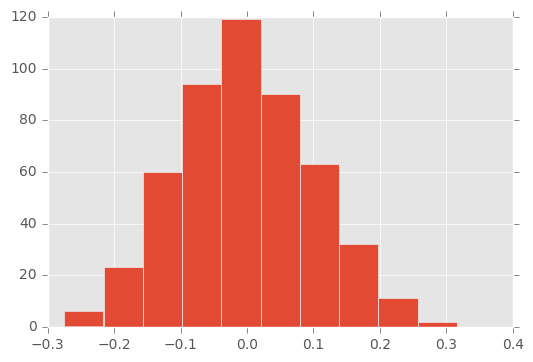

In [9]:
noise = np.random.normal(0, 0.1, size=[n_samples])
plt.hist(noise)

In [10]:
y_data = np.sin(x_data) + noise

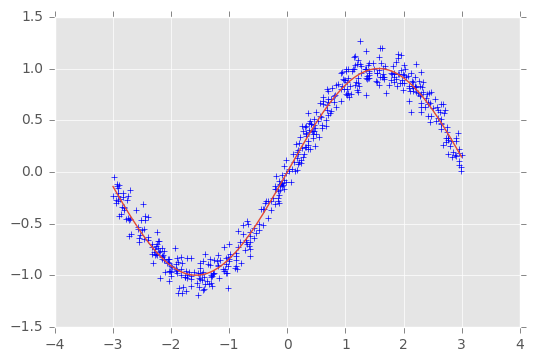

In [11]:
x_plot = np.sort(x_data)
plt.plot(x_plot, np.sin(x_plot))
plt.scatter(x_data, y_data, marker="+")

In [12]:
n_epochs = 8000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("started")
    feed_dict = {X: x_data.reshape((n_samples, 1)), Y: y_data.reshape((n_samples, 1))}
    
    for epoch in range(n_epochs):
        sess.run(optimizer, feed_dict=feed_dict)    
        if epoch % 500 == 0:
            current_cost = sess.run(cost, feed_dict=feed_dict)
            print("Cost: ", current_cost)
    
    trained_w1, trained_b1, trained_w2, trained_b2 = sess.run([w1, b1, w2, b2])
    
    x_test = np.linspace(-3, 3, 100)
    y_test = output.eval(feed_dict={X: x_test.reshape(100, 1)}, session=sess)
            

started
Cost:  1.88744
Cost:  0.161891
Cost:  0.0788748
Cost:  0.0729539
Cost:  0.0677296
Cost:  0.0617698
Cost:  0.0559022
Cost:  0.0496089
Cost:  0.039443
Cost:  0.0281175
Cost:  0.0230949
Cost:  0.0205957
Cost:  0.01854
Cost:  0.0164835
Cost:  0.0145553
Cost:  0.0130629


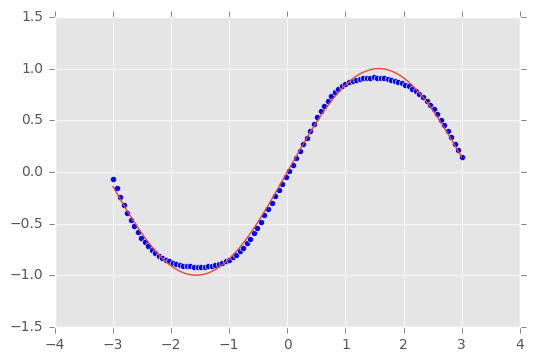

In [13]:
plt.plot(x_plot, np.sin(x_plot))
plt.scatter(x_test, y_test)

### Test and visualize

In [14]:
def app_sin(x):
    return np.tanh(np.tanh(x @ trained_w1 + trained_b1) @ trained_w2 + trained_b2)

y_test_2 = app_sin(x_test.reshape(100, 1))

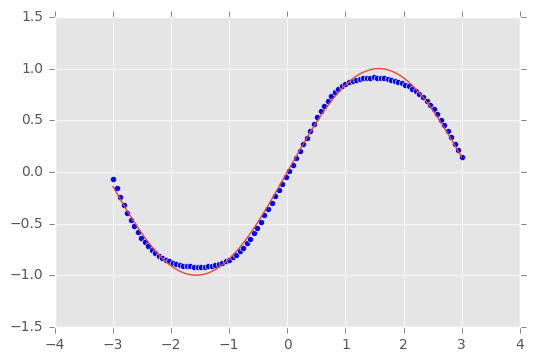

In [15]:
plt.plot(np.sort(x_data), np.sin(np.sort(x_data)))
plt.scatter(x_test, y_test_2)